In [44]:
import ipywidgets as widgets

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools

from sklearn.metrics import accuracy_score, auc, roc_auc_score

%run c:/code/python/pyIDS/main.py

from pyids.data_structures.ids_rule import IDSRule
from pyids.data_structures.ids_ruleset import IDSRuleSet
from pyids.data_structures.ids_objective_function import ObjectiveFunctionParameters, IDSObjectiveFunction
from pyids.data_structures.ids_optimizer import RSOptimizer, SLSOptimizer
from pyids.data_structures.ids_cacher import IDSCacher
from pyids.data_structures.ids_classifier import IDS, mine_CARs

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

from pyarc.qcba import *
from pyarc.qcba.data_structures import (
    IntervalReader,
    Interval,
    QuantitativeDataFrame,
    QuantitativeCAR
)

interval_reader = IntervalReader()

interval_reader.closed_bracket = "<", ">"
interval_reader.open_bracket = "(", ")"
interval_reader.infinity_symbol = "-inf", "+inf"
interval_reader.members_separator = ";"

interval_reader.compile_reader()

QuantitativeCAR.interval_reader = interval_reader


%matplotlib inline

In [46]:
import sys

class IDSVisualization:

    def __init__(self, rules, quant_dataframe, figsize=(10, 10)):
        if type(quant_dataframe) != QuantitativeDataFrame:
            raise Exception("type of quant_dataframe must be QuantitativeDataFrame")

        self.rules = rules
            
        self.pd_dataframe = quant_dataframe.dataframe
        self.colnames = list(self.pd_dataframe.columns)
        self.colnames_len = len(self.colnames)
        self.colnames_x = self.colnames[:self.colnames_len - 1]
        self.colnames_y = self.colnames[self.colnames_len - 1] 
        
        self.colors = ["red", "green", "blue", "black", "cyan", "yellow", "magenta", "lightblue", "lightgreen"]
        self.classes = list(self.pd_dataframe[self.colnames_y].values)
        self.classes_numbers_encoding = list(range(len(self.classes))) 
        self.classes_unique = list(set(self.classes))
        self.classes_numbers = [ self.classes_numbers_encoding[self.classes_unique.index(clazz)] for clazz in self.classes ]
        self.classes_numbers_dict = { clazz:self.classes_numbers_encoding[self.classes_unique.index(clazz)] for clazz in self.classes_unique }
        self.colors_map = self._get_color_map()
        self.colors_unique = [ self.colors_map[clazz] for clazz in self.classes_unique ]
        
        self.colnames_x_combinations = list(itertools.combinations(self.colnames_x, 2))
        
        self.column_extremas = self._get_column_extremas()
            
        
        self.figsize = figsize
        self.figure = None
        self.axes = None
        
    def _get_color_map(self):
        classes_unique = set(self.classes)
        
        colors_map = dict()
        
        for idx, class_label in enumerate(classes_unique):
            colors_map.update({class_label: self.colors[idx]})
            
        return colors_map
    
    def _get_column_extremas(self):
        column_extremas = dict()
        
        for column in self.pd_dataframe.columns:
            minval = self.pd_dataframe[column].min()
            maxval = self.pd_dataframe[column].max()

            column_extremas.update({column: (minval, maxval)})
        
        for rule in self.rules:
            for column, interval in rule.antecedent:
                minval, maxval = interval.minval, interval.maxval
                
                current_minval, current_maxval = column_extremas.get(
                    column,
                    (self.pd_dataframe[column].min(), self.pd_dataframe[column].max())
                )
                
                if minval > current_minval:
                    minval = current_minval
                    
                if maxval < current_maxval:
                    maxval = current_maxval
                    
                column_extremas.update({column: (minval, maxval)})
        
        return column_extremas
        
    def _prepare_figure(self):
        fig_columns = 2
        fig_rows = int(np.ceil(self.colnames_len / 2))
        
        if len(self.colnames) - 1 == 2:
            fig_columns = 1
            fig_rows = 1
        
        fig, axes = plt.subplots(fig_rows, fig_columns, figsize=self.figsize)
        
        if len(self.colnames) - 1 == 2:
            axes = np.array([axes])
        
        axes = axes.reshape(fig_columns * fig_rows)
        #fig.set_size_inches(*figsize)
        
        self.fig = fig
        self.axes = axes
        

    def visualize_IDS(self):
        self._prepare_figure()
        
        self._visualize_rules()
        self._visualize_dataframe()
        
    def visualize_dataframe(self):
        self._prepare_figure()
        
        self._visualize_dataframe()
        

    def _visualize_dataframe(self):
        for idx, ax in enumerate(self.axes):
            col_x, col_y = self.colnames_x_combinations[idx]
            
            x = self.pd_dataframe[col_x]
            y = self.pd_dataframe[col_y]
            
            colours = ListedColormap(self.colors_unique)
            
            scatter = ax.scatter(x, y, c=self.classes_numbers, cmap=colours)
            ax.set_xlabel(col_x)
            ax.set_ylabel(col_y)
            ax.set_title("Scatter of '{}' vs '{}'".format(col_x, col_y))
            ax.grid()
            ax.legend(handles=scatter.legend_elements()[0], labels=self.classes_numbers_dict.keys())
            
            if len(self.colnames_x_combinations) == 1 and idx == 0:
                break
    
    
    def _rule_covers_whole_subspace(self):
        return False
    
    
    def _substitute_infinities(self, colname, minval, maxval):
        if minval == -np.inf:
            minval = self.column_extremas[colname][0]
        
        if maxval == np.inf:
            maxval = self.column_extremas[colname][1]
    
        return minval, maxval
    
    
    def _create_rule_rectangle(self, ax_idx, antecedent_dict):
        col_x, col_y = self.colnames_x_combinations[ax_idx]
                
        column_x_extrema = self.column_extremas[col_x]
        column_y_extrema = self.column_extremas[col_y]

        interval_x = antecedent_dict.get(col_x, Interval(*column_x_extrema, True, True))
        interval_y = antecedent_dict.get(col_y, Interval(*column_y_extrema, True, True))

        rule_x_min, rule_x_max = interval_x.minval, interval_x.maxval
        rule_y_min, rule_y_max = interval_y.minval, interval_y.maxval
        
        rule_x_min, rule_x_max = self._substitute_infinities(col_x, rule_x_min, rule_x_max)
        rule_y_min, rule_y_max = self._substitute_infinities(col_y, rule_y_min, rule_y_max)
        
        
        if (rule_x_min, rule_x_max) == column_x_extrema and (rule_y_min, rule_y_max) == column_y_extrema:
            return None
        
        rect_width = rule_x_max - rule_x_min
        rect_height = rule_y_max - rule_y_min
        
        rect = Rectangle((rule_x_min, rule_y_min), rect_width, rect_height)
        
        return rect
        
    
    def _visualize_rules(self):
        for ax_idx, ax in enumerate(self.axes):
            ax_rule_patches = []
            
            for rule in self.rules:
                antecedent_dict = dict(rule.antecedent)
                
                rule_rect = self._create_rule_rectangle(ax_idx, antecedent_dict)
                
                if rule_rect:
                    rule_class = rule.consequent.value
                    class_color = self.colors_map[rule_class]
                    rule_alpha = rule.confidence * 0.25
                    
                    rule_rect.set_fill(True)
                    rule_rect.set_color(class_color)
                    rule_rect.set_alpha(rule_alpha)
                    
                    ax_rule_patches.append(rule_rect)
            
            
            for rect in ax_rule_patches:
                ax.add_patch(rect)
                
            if len(self.colnames_x_combinations) == 1 and ax_idx == 0:
                break

In [47]:
df_undiscr = pd.read_csv("../data/movies.csv", sep=";")
df_discr = pd.read_csv("../data/movies_discr.csv", sep=";")
df_discr = df_discr.iloc[:, 1:]

In [48]:
cars0 = mine_CARs(df_discr, 3, sample=True)
cars1 = mine_CARs(df_discr, 7, sample=False)
cars = cars0 + cars1

quant_cars = list(map(QuantitativeCAR, cars))

quant_df = QuantitativeDataFrame(df_undiscr)

ids = IDS()
ids.fit(quant_df, cars, debug=False)



Running apriori with setting: confidence=0.5, support=0.0, minlen=2, maxlen=3, MAX_RULE_LEN=3
Rule count: 45, Iteration: 1
Decreasing confidence to 0.45
Running apriori with setting: confidence=0.45, support=0.0, minlen=2, maxlen=3, MAX_RULE_LEN=3
Rule count: 45, Iteration: 2
Decreasing confidence to 0.4
Running apriori with setting: confidence=0.4, support=0.0, minlen=2, maxlen=3, MAX_RULE_LEN=3
Rule count: 45, Iteration: 3
Decreasing confidence to 0.35000000000000003
Running apriori with setting: confidence=0.35000000000000003, support=0.0, minlen=2, maxlen=3, MAX_RULE_LEN=3
Rule count: 45, Iteration: 4
Decreasing confidence to 0.30000000000000004
Running apriori with setting: confidence=0.30000000000000004, support=0.0, minlen=2, maxlen=3, MAX_RULE_LEN=3
Rule count: 45, Iteration: 5
Decreasing confidence to 0.25000000000000006
Running apriori with setting: confidence=0.25000000000000006, support=0.0, minlen=2, maxlen=3, MAX_RULE_LEN=3
Rule count: 45, Iteration: 6
Decreasing confiden

In [49]:
viz = IDSVisualization(quant_cars, quant_df, figsize=(6, 6))

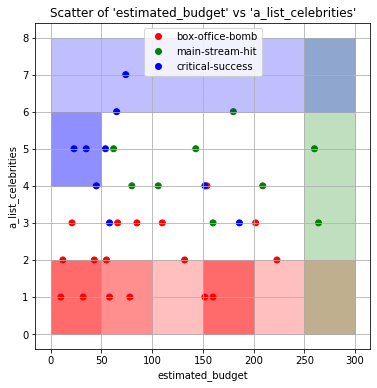

In [50]:
viz.visualize_IDS()

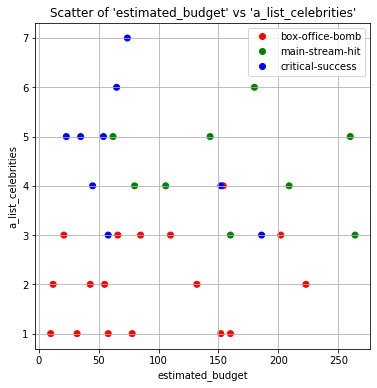

In [51]:
viz.visualize_dataframe()

In [52]:
def print_cars(ids_cars):
    cars = [ r.car for r in ids_cars ]
    latex = []
    for car in cars:
        latex.append(car_to_latex(car))
        
    return "\n\n".join(latex)
        
def car_to_latex(car):
    latex = []
    
    latex.append("If")
    
    for predicate in car.antecedent:
        name, interval = predicate
        name = name.translate(str.maketrans({"-":  r"\-",
                                  "_":  r"\_",
                                  "]":  r"\]",
                                  "\\": r"\\",
                                  "^":  r"\^",
                                  "$":  r"\$",
                                  "*":  r"\*",
                                  ".":  r"\."}))
        
        interval_string = interval
        
        latex.append(
            f"\\textcolor{{blue}}{{{name}}}=\\textcolor{{gray}}{{{interval_string}}}"
        )

        
    class_name, class_value = car.consequent
    
    latex.append("then")
    latex.append(
        f"\\textcolor{{red}}{{{class_name}}}=\\textcolor{{gray}}{{{class_value}}}"
    )
    
    return " ".join(latex)
        
print(print_cars(ids.clf.rules))

If \textcolor{blue}{a\_list\_celebrities}=\textcolor{gray}{<0;2)} then \textcolor{red}{class}=\textcolor{gray}{box-office-bomb}

If \textcolor{blue}{a\_list\_celebrities}=\textcolor{gray}{<0;2)} \textcolor{blue}{estimated\_budget}=\textcolor{gray}{<0;50)} then \textcolor{red}{class}=\textcolor{gray}{box-office-bomb}

If \textcolor{blue}{a\_list\_celebrities}=\textcolor{gray}{<0;2)} \textcolor{blue}{estimated\_budget}=\textcolor{gray}{<50;100)} then \textcolor{red}{class}=\textcolor{gray}{box-office-bomb}


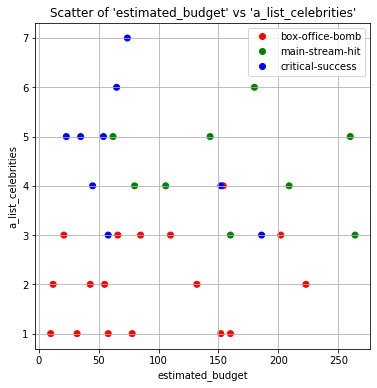

In [53]:
viz.visualize_dataframe()


## f0

In [54]:
viz_f0_0 = IDSVisualization(quant_cars, quant_df, figsize=(6, 6))
viz_f0_1 = IDSVisualization(quant_cars[:4], quant_df, figsize=(6, 6))

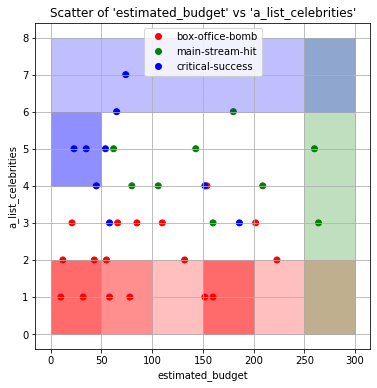

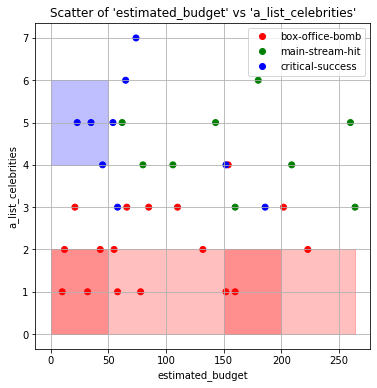

In [55]:
viz_f0_0.visualize_IDS()
viz_f0_1.visualize_IDS()

In [56]:
quant_cars

[CAR {a_list_celebrities=<4.0;6.0),estimated_budget=<0.0;50.0)} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 200,
 CAR {a_list_celebrities=<0.0;2.0),estimated_budget=<150.0;200.0)} => {class=box-office-bomb} sup: 0.06 conf: 1.00 len: 3, id: 203,
 CAR {a_list_celebrities=<0.0;2.0),estimated_budget=<0.0;50.0)} => {class=box-office-bomb} sup: 0.11 conf: 1.00 len: 3, id: 193,
 CAR {a_list_celebrities=<0.0;2.0)} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 226,
 CAR {a_list_celebrities=<0.0;2.0),estimated_budget=<0.0;50.0)} => {class=box-office-bomb} sup: 0.11 conf: 1.00 len: 3, id: 238,
 CAR {a_list_celebrities=<0.0;2.0),estimated_budget=<50.0;100.0)} => {class=box-office-bomb} sup: 0.09 conf: 1.00 len: 3, id: 229,
 CAR {estimated_budget=<250.0;300.0)} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 266,
 CAR {a_list_celebrities=<4.0;6.0),estimated_budget=<0.0;50.0)} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 245,
 CAR {a_list_ce

## f1

In [57]:
viz_f1_0 = IDSVisualization(quant_cars, quant_df, figsize=(6, 6))
viz_f1_1 = IDSVisualization([ car for car in quant_cars if len(car.antecedent) == 1 ], quant_df, figsize=(6, 6))

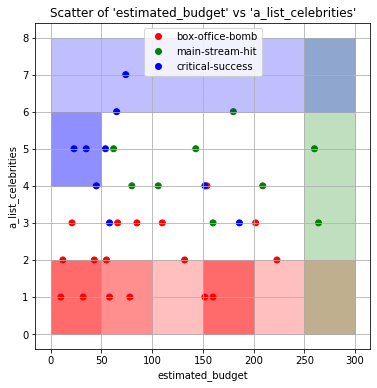

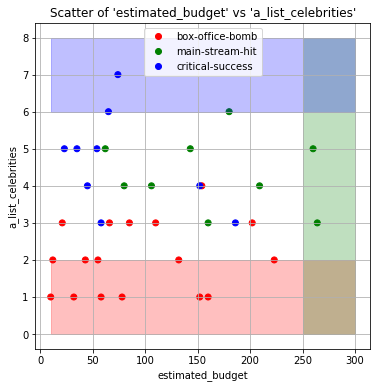

In [58]:
viz_f1_0.visualize_IDS()
viz_f1_1.visualize_IDS()

## f2

In [60]:
rules_f2_0 = [car for car in quant_cars if car.consequent[1] == "box-office-bomb" ]
rules_f2_1 = [ car for car in quant_cars if car.consequent[1] == "main-stream-hit" ]

viz_f2_0 = IDSVisualization(rules_f2_0, quant_df, figsize=(6, 6))
viz_f2_1 = IDSVisualization(rules_f2_1, quant_df, figsize=(6, 6))

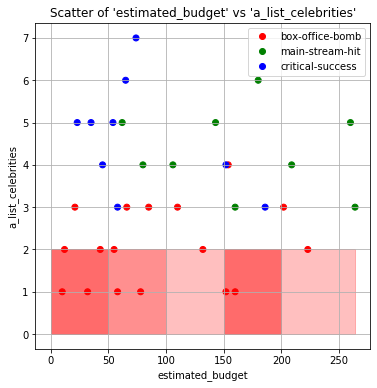

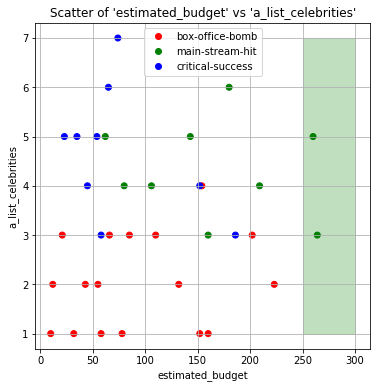

In [61]:
viz_f2_0.visualize_IDS()
viz_f2_1.visualize_IDS()

## f3

In [33]:
def two_classes_predicate(car):
    return car.consequent[1] in ["critical-success", "box-office-bomb"]

def minimize_overlap_heuristically_predicate(car):
    return len(car.antecedent) == 2

rules_f3_0 = [car for car in quant_cars if two_classes_predicate(car) and minimize_overlap_heuristically_predicate(car) ]
rules_f3_1 = [ car for car in quant_cars[:5] ]

viz_f3_0 = IDSVisualization(rules_f3_0, quant_df, figsize=(6, 6))
viz_f3_1 = IDSVisualization(rules_f3_1, quant_df, figsize=(6, 6))

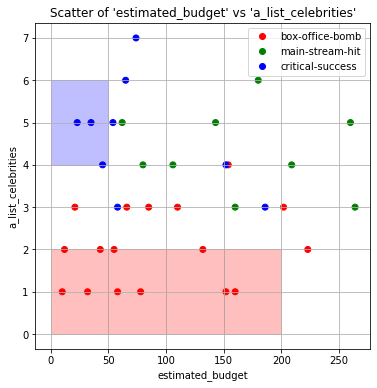

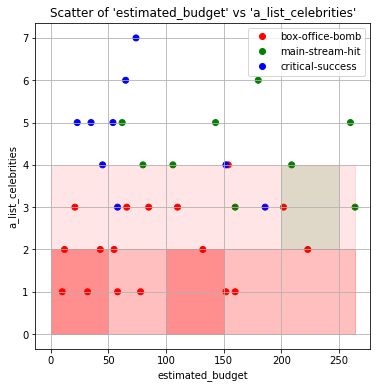

In [34]:
viz_f3_0.visualize_IDS()
viz_f3_1.visualize_IDS()

## f4

In [22]:
viz_f4_0 = IDSVisualization(quant_cars, quant_df, figsize=(6, 6))
viz_f4_1 = IDSVisualization([ car for car in quant_cars if car.consequent[1] != "critical-success" ], quant_df, figsize=(6, 6))

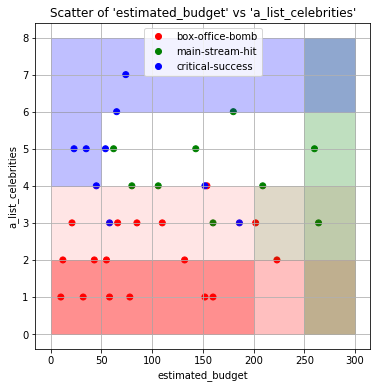

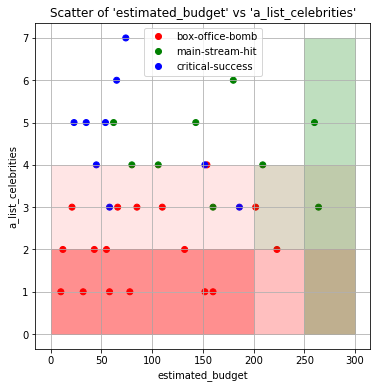

In [23]:
viz_f4_0.visualize_IDS()
viz_f4_1.visualize_IDS()

## f5

In [24]:
viz_f5_0 = IDSVisualization([ car for car in quant_cars if car.confidence >= 0.9 ], quant_df, figsize=(6, 6))
viz_f5_1 = IDSVisualization([ car for car in quant_cars if car.confidence < 0.9 ], quant_df, figsize=(6, 6))

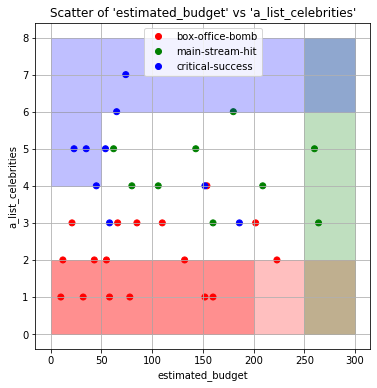

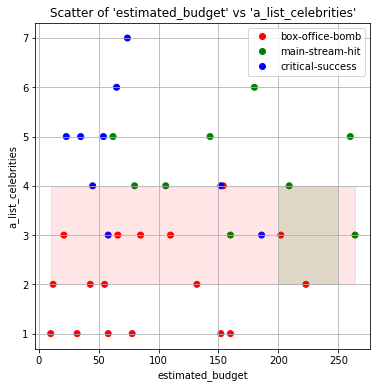

In [25]:
viz_f5_0.visualize_IDS()
viz_f5_1.visualize_IDS()

## f6

In [26]:
viz_f6_0 = IDSVisualization(quant_cars, quant_df, figsize=(6, 6))
viz_f6_1 = IDSVisualization([ car for car in quant_cars if car.support < 0.05 ], quant_df, figsize=(6, 6))

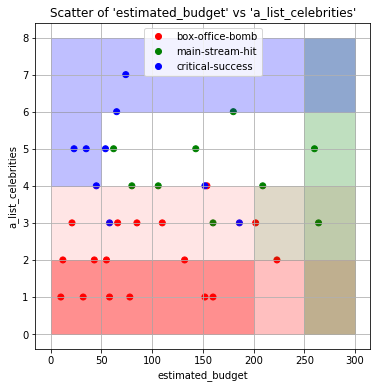

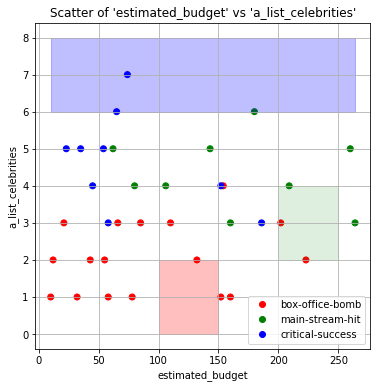

In [27]:
viz_f6_0.visualize_IDS()
viz_f6_1.visualize_IDS()